# oceanarray demo - mooring-level processing

This notebook walks through the instrument-level processing.


In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import numpy as np
from oceanarray import readers, rodb, mooring, plotters, tools


# Mooring-level processing

## Step 1: Load all the *.use files


In [2]:
data_dir = Path(".." ,"data")
input_file_pre = 'wb2_9_201114*use'
input_files = list(data_dir.glob(input_file_pre))
ds_list = [rodb.rodbload(f) for f in input_files]
#_2015_6123.raw'
#ds = rodb.rodbload(data_dir / input_file)

ds1 = ds_list[0]

Text(0.5, 0.98, '2-day filtered *.use')

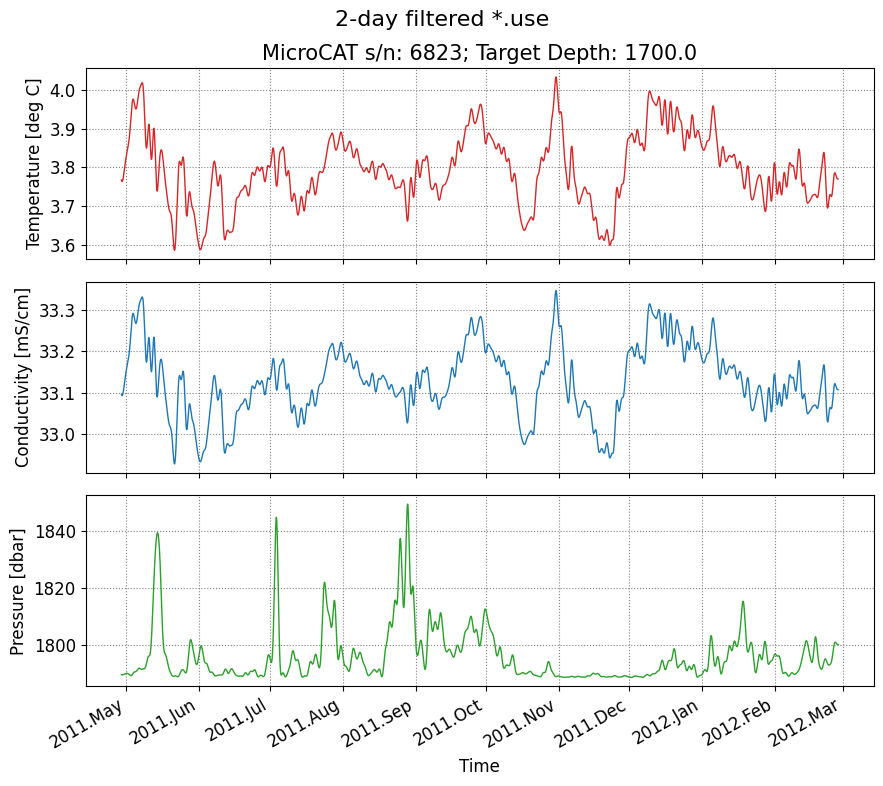

In [3]:
ds_filt = mooring.filter_all_time_vars(ds1)

fig = plotters.plot_microcat(ds_filt)
fig.suptitle("2-day filtered *.use", fontsize=16, y=0.98)


In [4]:
ds_li = [mooring.filter_all_time_vars(ds) for ds in ds_list]



In [5]:
ds_li[0]

<xarray.Dataset> Size: 1MB
Dimensions:         (TIME: 14639)
Coordinates:
    N_MEASUREMENTS  (TIME) int64 117kB 0 1 2 3 4 ... 14635 14636 14637 14638
  * TIME            (TIME) datetime64[s] 117kB 2011-04-28T20:00:00 ... 2012-0...
Data variables:
    YY              (TIME) float64 117kB 2.011e+03 2.011e+03 ... 2.012e+03
    MM              (TIME) float64 117kB 4.028 4.029 4.03 4.03 ... 2.0 2.0 2.0
    DD              (TIME) float64 117kB 27.11 27.12 27.14 ... 26.51 26.51 26.51
    HH              (TIME) float64 117kB 20.59 20.11 19.64 ... 11.71 11.71 11.71
    T               (TIME) float64 117kB 3.767 3.767 3.766 ... 3.77 3.77 3.77
    C               (TIME) float64 117kB 33.1 33.1 33.1 ... 33.11 33.11 33.11
    P               (TIME) float64 117kB 1.79e+03 1.79e+03 ... 1.8e+03 1.8e+03
    InstrDepth      float64 8B 1.7e+03
    Latitude        float64 8B 26.52
    Longitude       float64 8B -76.74
Attributes:
    mooring:        wb2_9_201114
    serial_number:  6823
    water_depth:    3880
    start_time:     2011/04/28T20:00
    end_time:       2012/02/27T19:00
    source_file:    ../data/wb2_9_201114_6823.use
    columns:        ['YY', 'MM', 'DD', 'HH', 'T', 'C', 'P']

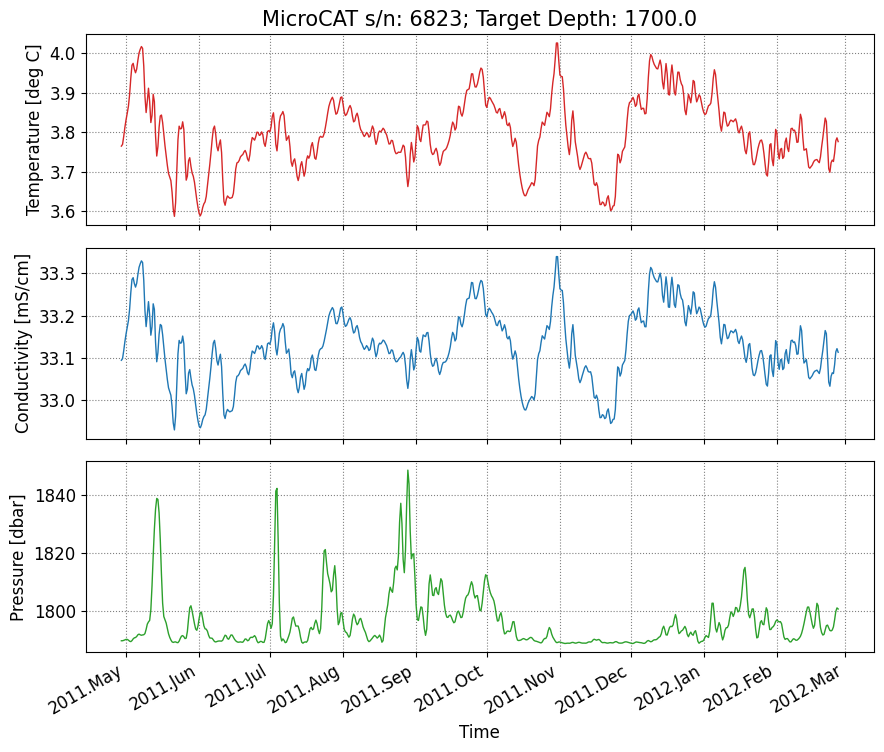

In [8]:
ds1 = ds_li[0]
ds_interp = mooring.interp_to_12hour_grid(ds1)
fig = plotters.plot_microcat(ds_interp)